# Übung 9, Aufgabe 3: Implizite Volatilität
## Import der Programmbibliotheken

In [ ]:
!pip install yfinance

In [ ]:
from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.core.display import display, HTML
import matplotlib.pyplot as plt
from scipy.misc import derivative
from ipywidgets import widgets
from scipy.stats import norm
import yfinance as yf
import pandas as pd
import numpy as np
import operator

## Grafikeinstellungen

In [ ]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [ ]:
%matplotlib inline

SCREEN_WIDTH = 100
SIZE = [15, 10]

pd.set_option('display.width', SCREEN_WIDTH)
centered = operator.methodcaller('center', SCREEN_WIDTH)
plt.rcParams["figure.figsize"] = SIZE[0], SIZE[1]

## Berechnung der impliziten Volatilität mittels der Newton-Raphson Methode
### Hilfsfunktionen

In [ ]:
# Berechnung Preis Call nach Black-Scholes
def bs_call(S, B, T, r, vol):
    d1 = (np.log(S / B) + (r + 0.5 * vol**2) * T) / (vol * np.sqrt(T))
    d2 = d1 - vol * np.sqrt(T)
    return (S * norm.cdf(d1) - np.exp(-r * T) * B * norm.cdf(d2))

# Berechnunng Vega
def calc_vega(S, B, T, r, sigma):
    d1 = (np.log(S / B) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    return (S * norm.pdf(d1) * np.sqrt(T))

### Implementierung der Newton-Raphson Methode

In [ ]:
def calc_implied_vol(S, B, T, r, c_market, tol=0.00001, max_iter=7500, vol_old=0.3):

    for i in range(max_iter):
        # Berechnung des theoretischen Call-Preises
        bs_price = bs_call(S, B, T, r, vol_old)
        # Berechnung Vega
        vega = (calc_vega(S, B, T, r, vol_old))
        # Berechnung der Differenz zwischen theoretischen und empirischen Call-Preis
        diff = (bs_price - c_market)

        # Neue Approximation der Volatilität
        vol_new = vol_old - (diff / vega)
        # Berechnung Call-Preis unter Verwendung der neuen Approximation
        new_bs_price = bs_call(S, B, T, r, vol_new)

        # Abbruchkriterium
        if (abs(vol_old - vol_new) < tol or abs(new_bs_price - c_market) < tol):
            break

        # Update der Volatilität
        vol_old = vol_new

    # Ausgabe der berechneten Volatilität
    implied_vol = vol_new
    return implied_vol

### Berechnung der impliziten Volatilität an einem Beispiel

In [ ]:
S = 30
B = 28
T = 0.5
r = 0.025
c_market = 3.7

print('Die implizite Volatilität beträgt {}%.'.format(round((calc_implied_vol(S, B, T, r, c_market) * 100), 2)))

Die implizite Volatilität beträgt 28.86%.


## Analyse der impliziten Volatilität anhand von Marktdaten

#----------------------------------------------------------------------------------------------------#
|                           Folgende Unternehmen können ausgewählt werden:                           | 
#----------------------------------------------------------------------------------------------------#
0) Apple
1) Amazon
2) Microsoft
3) Tesla
#----------------------------------------------------------------------------------------------------#
|                   Bitte geben Sie namentlich ein Unternehmen aus der Liste ein:                    | Microsoft
#----------------------------------------------------------------------------------------------------#
|               Für Microsoft sind Optionen mit den folgenden Fälligkeiten verfügbar:                | 
#----------------------------------------------------------------------------------------------------#
0) 2022-01-07
1) 2022-01-14
2) 2022-01-21
3) 2022-01-28
4) 2022-02-04
5) 2022-02-11
6) 2022-02-18
7) 2022-03-18
8) 2022-04-

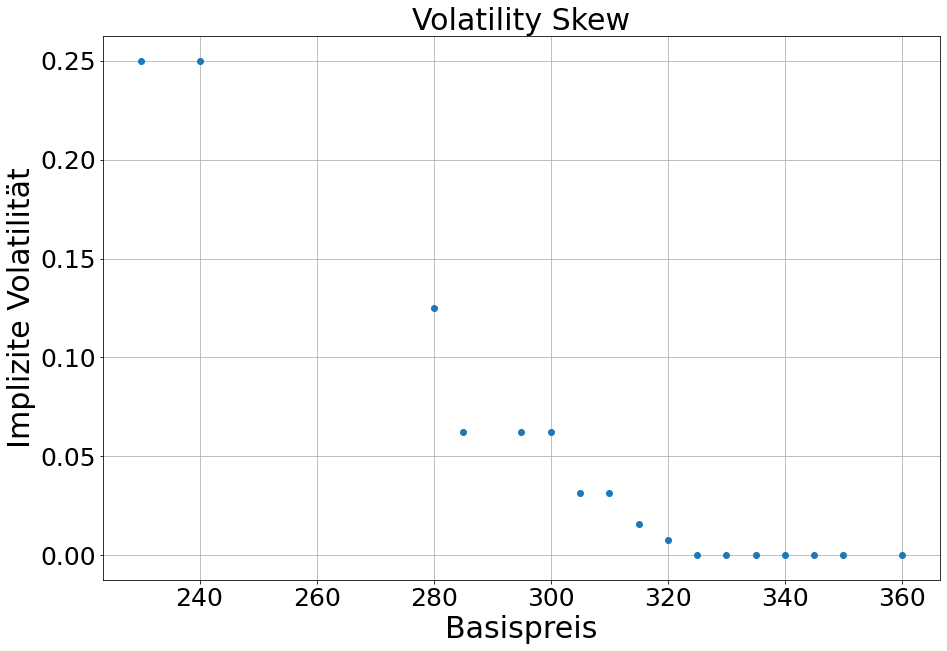

In [ ]:
# Dictonary in dem die Ticker-Kürzel hinterlegt sind
company_dict = {"Apple": 'AAPL',
                "Amazon": 'AMZN',
                "Microsoft": 'MSFT',
                "Tesla": 'TSLA'}

# Abfrage zur Auswahl des Unternehmens
print('#' + SCREEN_WIDTH * '-' + '#')
print('|' + centered('Folgende Unternehmen können ausgewählt werden:') + '| ')
print('#' + SCREEN_WIDTH * '-' + '#')
counter = 0
for key, value in company_dict.items() :
    print(str(counter) + ') ' + str(key))
    counter += 1
print('#' + SCREEN_WIDTH * '-' + '#')
selected_company = input('|' + centered('Bitte geben Sie namentlich ein Unternehmen aus der Liste ein:') + '| ')

# Ausgabe verfügbare Fälligkeiten
selected_company_obj = yf.Ticker(company_dict[selected_company])
print('#' + SCREEN_WIDTH * '-' + '#')
print('|' + centered('Für ' + str(selected_company) + ' sind Optionen mit den folgenden Fälligkeiten verfügbar:') + '| ')
print('#' + SCREEN_WIDTH * '-' + '#')
maturitys = selected_company_obj.options
counter = 0
for maturity in maturitys:
    print(str(counter) + ') ' + str(maturity))
    counter += 1
print('#' + SCREEN_WIDTH * '-' + '#')

# Wahl eines Fälligkeitstermins
selected_maturity = int(input('|' + centered('Bitte geben Sie die Nummer der gewünschten Fälligkeit ein:') + '| '))
print('#' + SCREEN_WIDTH * '-' + '#')
company_options = selected_company_obj.option_chain(selected_company_obj.options[selected_maturity])
option_data = company_options.puts

# Vereinfachter DataFrame mit Informationen zu den Kontrakten
stock_overview = pd.DataFrame({'Bezeichnung':option_data['contractSymbol'], 'Strike':option_data['strike'], 'Bid':option_data['bid'], 'Ask':option_data['ask'], 'Implizite Volatilität':option_data['impliedVolatility'], 'InTheMoney':option_data['inTheMoney']})
print('|' + centered('Ausgewählt wurde ' + str(selected_company) + ' zur Fälligkeit ' + str(selected_company_obj.options[selected_maturity]) + '.') + '| ')
print('#' + SCREEN_WIDTH * '-' + '#')
print(stock_overview)
print('#' + SCREEN_WIDTH * '-' + '#')

# Generierung der Grafik
x = option_data['strike']
y = list(option_data['impliedVolatility'])
plt.title('Volatility Skew', fontsize=30)
plt.ylabel('Implizite Volatilität', fontsize=30)
plt.xlabel('Basispreis', fontsize=30)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.plot(x,y, 'o')
plt.grid()
plt.show()

## Exkurs: Funktionsprinzip Newton-Raphson Methode

In [ ]:
# Erzeugung Wertebereich
x = np.linspace(-1.5, 2.2, 500)

# Definition Funktion
def f(x):
    return x**2

# Erzeugt Tangente, Nullstelle
def f_line(f, x, x_n):
    slope = derivative(f, x_n, dx=0.1)
    x_nn = x_n - f(x_n) / slope
    return slope * (x - x_n) + f(x_n), x_nn

# Hilfsfunktion zur Erzeugung der interaktiven Grafik
def update_plot(order):
    fig, ax = plt.subplots(1, figsize=(13, 6.5))
    x_n = 2
    ax.clear()
    ax.plot(x, f(x), label='f(x)=x^2')
    ax.axhline(0, color='gray', lw=0.5)

    for i in range(0, order):
        if i >= 1:
            ax.plot(x, f_l, '--', lw=1)
        ax.plot(x_n, f(x_n), 'kd', label=r'$f(x_{}={:.2f})={:.3f}$'.format(i + 1, x_n, f(x_n)))
        ax.vlines(x_n, 0, f(x_n), color='black', linestyle=':', lw=1)
        f_l, x_n = f_line(f, x, x_n)

    ax.set_ylim(-1, 5)
    ax.set_xlim(-1.0, 2.2)
    ax.legend(loc=4)
    ax.grid()

### Ausgabe interaktive Grafik

In [ ]:
order = widgets.IntSlider(min=1, max=6, value=1, description='order')
interact(update_plot, order=order);

interactive(children=(IntSlider(value=1, description='order', max=6, min=1), Output()), _dom_classes=('widget-…